# Exploratory Analysis of the US Health Insurance Market from 2014-2016

This notebook does an exploratory analysis of the US Health Insurance Market from 2014-2016 provided as an sqlite database on Kaggle. The database is nearly 4 GB, so it was downloaded manually and placed in the folder 'data'.

In [12]:
# import relevant libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sqla
from decimal import Decimal as D


# Create TypeDecorator for Numeric Data in SQLite

class SqliteNumeric(sqla.types.TypeDecorator):
    
    # Representation in SQLite
    impl = sqla.types.String
    
    # Define methods for reading and writing to database
    def process_bind_param(self, value, dialect):
        return str(value)
    def process_result_value(self, value, dialect):
        if value != "None":
            return D(value)
        else:
            return None

# Use SqliteNumeric to handle Numeric data in SQlite    
Numeric = SqliteNumeric

## Connection to Database and Examination of Database Structure

In [14]:
# Connect to engine

metadata = sqla.MetaData()

engine =  sqla.create_engine("sqlite:///data/database.sqlite")

table_names = engine.table_names()

tables = dict()

for table in table_names:
    print(table+" Column Names:\n")
    tables[table] = sqla.Table(table, metadata, autoload=True, autoload_with=engine)
    print(tables[table].columns.keys())
    print("\n")

BenefitsCostSharing Column Names:

['BenefitName', 'BusinessYear', 'CoinsInnTier1', 'CoinsInnTier2', 'CoinsOutofNet', 'CopayInnTier1', 'CopayInnTier2', 'CopayOutofNet', 'EHBVarReason', 'Exclusions', 'Explanation', 'ImportDate', 'IsCovered', 'IsEHB', 'IsExclFromInnMOOP', 'IsExclFromOonMOOP', 'IsStateMandate', 'IsSubjToDedTier1', 'IsSubjToDedTier2', 'IssuerId', 'IssuerId2', 'LimitQty', 'LimitUnit', 'MinimumStay', 'PlanId', 'QuantLimitOnSvc', 'RowNumber', 'SourceName', 'StandardComponentId', 'StateCode', 'StateCode2', 'VersionNum']


BusinessRules Column Names:

['BusinessYear', 'StateCode', 'IssuerId', 'SourceName', 'VersionNum', 'ImportDate', 'IssuerId2', 'TIN', 'ProductId', 'StandardComponentId', 'EnrolleeContractRateDeterminationRule', 'TwoParentFamilyMaxDependentsRule', 'SingleParentFamilyMaxDependentsRule', 'DependentMaximumAgRule', 'ChildrenOnlyContractMaxChildrenRule', 'DomesticPartnerAsSpouseIndicator', 'SameSexPartnerAsSpouseIndicator', 'AgeDeterminationRule', 'MinimumTobaccoFre

This database contains 6 tables describing the insurance rates (Rate), insurance plan attributes (PlanAttributes), business rules (BusinessRules), Service area covered (ServiceArea), and cost sharing attributes of the insurance plan (BenefitsCostSharing). The remaining two tables provide continuity between years so that insurance plans can be joined across 2014, 2015, and 2016. (Crosswalk2015 and Crosswalk2016) Definitions of the fields in the database can be found [here](https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html). 

## Exploratory Analysis

The initial analysis focuses on the Rate table. There are several different insurance rates in this table depending on whether the insurance plan applies to an individual, a individual who smokes, a couple, an individual with dependents, or a couple with dependents. First, we construct a dataframe of the IndividualRates (regardless of state) for 2016 that are not 9999 or have a Family Option, which indicates that the plan is some other type. Then, we calculate summary statistics of these rates. Finally, we make a histogram of individual rates.

       IndividualRate
count    4.197006e+06
mean     3.184305e+02
std      3.035833e+02
min      0.000000e+00
25%      2.850000e+01
50%      2.968500e+02
75%      4.873500e+02
max      2.421000e+03


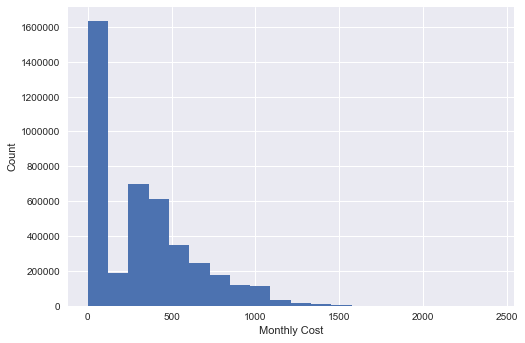

In [20]:

# Generate SQL statement

conn = engine.connect()

# Equivalent to SELECT IndividualRate FROM Rate
stmt = sqla.select([tables["Rate"].columns.IndividualRate])

# Adds where clause: 
# SELECT IndividualRate FROM Rate 
# WHERE BusinessYear = 2016 and Age != 'Family Option' and IndividualRate < 9000
stmt = stmt.where(sqla.and_(tables["Rate"].columns.BusinessYear == 2016,
                            tables["Rate"].columns.Age != "Family Option",
                           tables["Rate"].columns.IndividualRate < 9000))
!
rates = pd.read_sql(stmt, conn)

print(rates.describe())
                  
plt.hist(rates['IndividualRate'], bins = 20)
plt.xlabel("Monthly Cost")
plt.ylabel("Count")
plt.show()



There seems to be quite a few plans where the monthly rate is 0, but the reason why is unclear. These could be subsidized plans or perhaps we did not filter out the data correctly. As a check, we replot the histogram with the zero values filtered out.

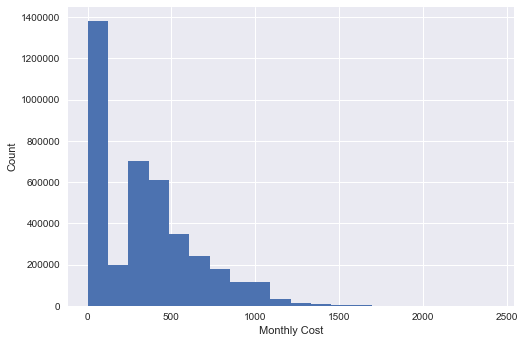

In [21]:
plt.hist(rates['IndividualRate'][rates['IndividualRate'] > 0], bins = 20)
plt.xlabel("Monthly Cost")
plt.ylabel("Count")
plt.show()

Many low cost plans remain, so perhaps several people buy insurance just at the cost of the subsidy. Under ACA, the second cheapest silver plan gets a full subsidy at the lower income levels. Therefore, we should investigate the cost of the plans as a function of the 'metal'. In addition, dental plans are included on the marketplace, so we should filter these out to see if they are contributing to the large peak near 0. To do so, we need to construct a more complex SQL query.